<a href="https://colab.research.google.com/github/Hyshubham2504/Clustering-Project/blob/main/First_Approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###**1. Import libraries**

In [100]:
import yfinance as yf
import pandas as pd
from bs4 import BeautifulSoup as bs
import requests
import numpy as np

from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

###**2. Get the latest list of S&P 500 companies from Slickcharts**

In [2]:
# Get the latest S&P 500 components symbols (list of companies' ticker symbols)
# Reference: https://www.reddit.com/r/algotrading/comments/mtgakn/free_api_to_get_up_to_date_list_of_all_sp_500/
url = 'https://www.slickcharts.com/sp500'
request = requests.get(url,headers={'User-Agent': 'Mozilla/5.0'})
soup = bs(request.text, "lxml")
stats = soup.find('table',class_='table table-hover table-borderless table-sm')

df =pd.read_html(str(stats))[0]

SP500_tickers = df['Symbol']

In [3]:
# Check if we got the ticker symbol correctly
print(SP500_tickers.head(), "\n")
print(SP500_tickers.describe())

0    MSFT
1    NVDA
2    AAPL
3    AMZN
4    META
Name: Symbol, dtype: object 

count      503
unique     503
top       MSFT
freq         1
Name: Symbol, dtype: object


###**3. Get the daily return data of the 500 companies from Yahoo Finance**
For the 20-year period 2004-01-01 — 2024-01-01 (YYYY-MM-dd).

In [4]:
# Temporary fix: Yahoo Finance uses "BRK-B" instead of "BRK.B" and "BF-B" instead of "BF.B"
# Replace these 2 tickers in the SP500_tickers list so that we can get their data from Yahoo Finance
SP500_tickers = list(map(lambda x: x.replace('BRK.B', 'BRK-B'), SP500_tickers))
SP500_tickers = list(map(lambda x: x.replace('BF.B', 'BF-B'), SP500_tickers))

In [5]:
# This can take 3-4 minutes
SP500_dict = {}

for ticker in SP500_tickers:
    ticker_yahoo = yf.Ticker(ticker)
    adj_close_data = ticker_yahoo.history(start="2004-01-01",  end="2024-01-01", auto_adjust=False, actions=False)["Adj Close"]
    SP500_dict[ticker] = adj_close_data.pct_change().dropna()

ERROR:yfinance:GEV: Data doesn't exist for startDate = 1072933200, endDate = 1704085200
ERROR:yfinance:SOLV: Data doesn't exist for startDate = 1072933200, endDate = 1704085200


In [6]:
daily_return_df = pd.DataFrame(SP500_dict)
descriptive_data = daily_return_df.describe()
descriptive_data

MSFT         NVDA         AAPL         AMZN         META  \
count  5032.000000  5032.000000  5032.000000  5032.000000  2922.000000   
mean      0.000758     0.001600     0.001487     0.001101     0.001082   
std       0.017031     0.030844     0.020802     0.024294     0.025280   
min      -0.147390    -0.352336    -0.179195    -0.218220    -0.263901   
25%      -0.007240    -0.013788    -0.008436    -0.010354    -0.010045   
50%       0.000401     0.001511     0.001137     0.000567     0.000999   
75%       0.008788     0.016473     0.012002     0.012433     0.012825   
max       0.186047     0.298067     0.139050     0.269497     0.296115   

             GOOGL         GOOG        BRK-B          LLY         AVGO  ...  \
count  4874.000000  4874.000000  5032.000000  5032.000000  3624.000000  ...   
mean      0.001011     0.001014     0.000457     0.000662     0.001505  ...   
std       0.019349     0.019367     0.013367     0.015634     0.022169  ...   
min      -0.116342    -0.116091    -0.109440    -0.123483    -0.199129  ...   
25%      -0.007991    -0.007862    -0.005608    -0.006768    -0.010267  ...   
50%       0.000769     0.000701     0.000170     0.000655     0.001441  ...   
75%       0.010137     0.010139     0.006389     0.007806     0.012932  ...   
max       0.199915     0.199915     0.192641     0.156798     0.158337  ...   

               FMC  SOLV         PAYC          IVZ          BEN          BIO  \
count  5032.000000   0.0  2444.000000  5032.000000  5032.000000  5032.000000   
mean      0.000708   NaN     0.001520     0.000526     0.000458     0.000514   
std       0.021727   NaN     0.029803     0.026851     0.021777     0.018676   
min      -0.208399   NaN    -0.384863    -0.211329    -0.152757    -0.167247   
25%      -0.008934   NaN    -0.012396    -0.011485    -0.009611    -0.008106   
50%       0.000529   NaN     0.002680     0.000340     0.000693     0.000415   
75%       0.010347   NaN     0.015996     0.012414     0.011021     0.008629   
max       0.225434   NaN     0.192893     0.280509     0.161147     0.205034   

               MHK         PARA          FOX          NWS  
count  5032.000000  4547.000000  1209.000000  2651.000000  
mean      0.000369     0.000367    -0.000008     0.000407  
std       0.024270     0.028343     0.021045     0.018604  
min      -0.242460    -0.283530    -0.104065    -0.145522  
25%      -0.010356    -0.012083    -0.010882    -0.009032  
50%       0.000144     0.000289    -0.000632     0.000000  
75%       0.010918     0.012249     0.010762     0.009424  
max       0.295611     0.307624     0.132469     0.132931  

[8 rows x 503 columns]

In [7]:
pd.set_option('display.max_rows', None)
descriptive_data.loc['count'].value_counts()

count
5032.0    385
2651.0      2
0.0         2
4165.0      2
2137.0      2
2370.0      2
952.0       2
4874.0      2
4922.0      1
1885.0      1
4792.0      1
3520.0      1
3554.0      1
4642.0      1
4658.0      1
3409.0      1
4901.0      1
4306.0      1
4072.0      1
3281.0      1
2203.0      1
2063.0      1
3047.0      1
2332.0      1
1739.0      1
60.0        1
4223.0      1
2314.0      1
3442.0      1
3949.0      1
4329.0      1
4651.0      1
3287.0      1
4505.0      1
4547.0      1
2444.0      1
2192.0      1
4595.0      1
4819.0      1
2755.0      1
1429.0      1
2334.0      1
3494.0      1
1210.0      1
5009.0      1
3215.0      1
2545.0      1
2992.0      1
2263.0      1
1794.0      1
4535.0      1
2144.0      1
4767.0      1
4627.0      1
2956.0      1
2925.0      1
4186.0      1
1508.0      1
1801.0      1
1820.0      1
2948.0      1
3223.0      1
767.0       1
3372.0      1
489.0       1
3388.0      1
4479.0      1
2746.0      1
4559.0      1
2408.0      1
4159.0      1


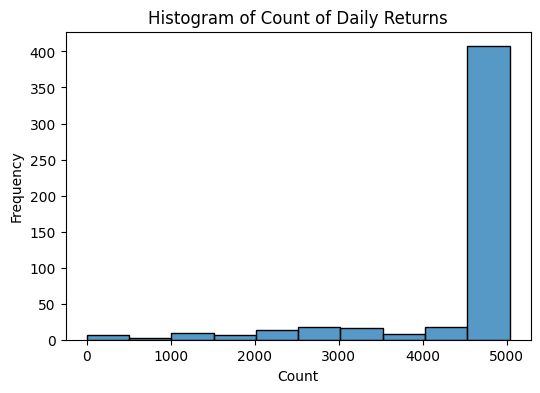

In [8]:
plt.figure(figsize=(6, 4))
sns.histplot(descriptive_data.loc['count'], bins=10, kde=False)
plt.title('Histogram of Count of Daily Returns')
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.show()

In [9]:
# Check if it's GEV and SOLV that have count = 0
daily_return_df[['GEV', 'SOLV']].describe()

GEV  SOLV
count  0.0   0.0
mean   NaN   NaN
std    NaN   NaN
min    NaN   NaN
25%    NaN   NaN
50%    NaN   NaN
75%    NaN   NaN
max    NaN   NaN

GEV: Founded on April 2, 2024 \
SOLV: Spun off from 3M (and hence founded) on April 1, 2024

In [10]:
# Check for missing values
daily_return_df.isnull().sum()

MSFT        0
NVDA        0
AAPL        0
AMZN        0
META     2110
GOOGL     158
GOOG      158
BRK-B       0
LLY         0
AVGO     1408
JPM         0
TSLA     1633
XOM         0
UNH         0
V        1059
PG          0
COST        0
MA        603
JNJ         0
MRK         0
HD          0
ABBV     2265
NFLX        0
WMT         0
CVX         0
BAC         0
AMD         0
KO          0
ADBE        0
CRM       118
PEP         0
QCOM        0
ORCL        0
TMO         0
LIN         0
WFC         0
AMAT        0
ACN         0
CSCO        0
DIS         0
MCD         0
ABT         0
INTU        0
TXN         0
GE          0
VZ          0
AMGN        0
DHR         0
CAT         0
PM       1057
PFE         0
IBM         0
ISRG        0
MU          0
NOW      2139
CMCSA       0
NEE         0
UBER     3864
GS          0
SPGI        0
HON         0
LRCX        0
UNP         0
BKNG        0
RTX         0
COP         0
T           0
AXP         0
INTC        0
ETN         0
TJX         0
ELV   

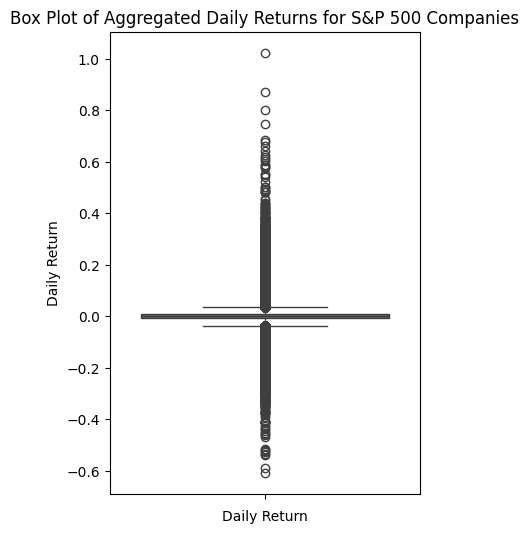

In [11]:
# aggregated_return: daily return of all companies combined into one list
aggregated_return = daily_return_df.stack()

plt.figure(figsize=(4, 6))
sns.boxplot(aggregated_return)
plt.title('Box Plot of Aggregated Daily Returns for S&P 500 Companies')
plt.xlabel('Daily Return')
plt.ylabel('Daily Return')
plt.show()

In [12]:
summary_statistics = aggregated_return.describe()
summary_statistics

count    2.301822e+06
mean     6.891329e-04
std      2.199503e-02
min     -6.079078e-01
25%     -8.536612e-03
50%      6.374407e-04
75%      9.849408e-03
max      1.023578e+00
dtype: float64

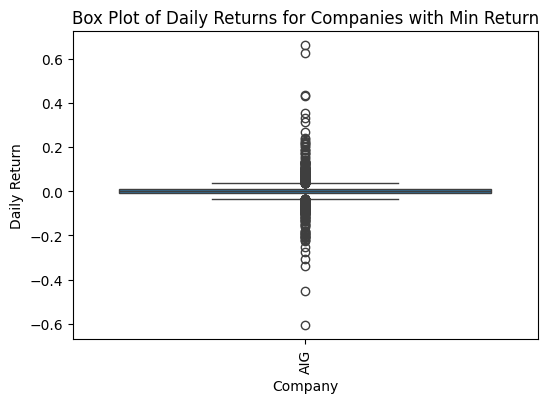

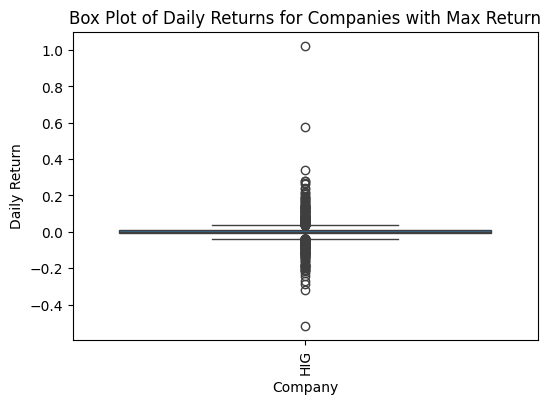

In [13]:
companies_min = daily_return_df.loc[:, (daily_return_df == summary_statistics['min']).any()].columns
companies_max = daily_return_df.loc[:, (daily_return_df == summary_statistics['max']).any()].columns

plt.figure(figsize=(6, 4))
sns.boxplot(daily_return_df[companies_min])
plt.title('Box Plot of Daily Returns for Companies with Min Return')
plt.xlabel('Company')
plt.ylabel('Daily Return')
plt.xticks(rotation=90)
plt.show()
plt.figure(figsize=(6, 4))
sns.boxplot(daily_return_df[companies_max])
plt.title('Box Plot of Daily Returns for Companies with Max Return')
plt.xlabel('Company')
plt.ylabel('Daily Return')
plt.xticks(rotation=90)
plt.show()

In [14]:
daily_return_df.index[daily_return_df['AIG'] == summary_statistics['min']]

Index([2008-09-15 00:00:00-04:00], dtype='object', name='Date')

In [15]:
daily_return_df.index[daily_return_df['HIG'] == summary_statistics['max']]

Index([2008-12-05 00:00:00-05:00], dtype='object', name='Date')

<Figure size 2000x600 with 0 Axes>

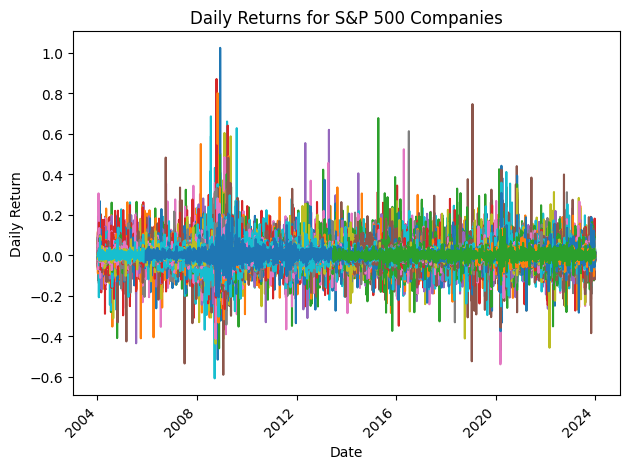

In [16]:
plt.figure(figsize=(20, 6))

daily_return_df.plot(legend=False)
plt.title('Daily Returns for S&P 500 Companies')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

AIG: American Internation Group Inc. \
AIG, a global company with about \$1 trillion in assets prior to the crisis, lost \$99.2 billion in 2008. On September 16 of that year, the Federal Reserve Bank of New York stepped in with an $85 billion loan to keep the failing company from going under.
https://insight.kellogg.northwestern.edu/article/what-went-wrong-at-aig#:~:text=AIG%2C%20a%20global%20company%20with,failing%20company%20from%20going%20under.
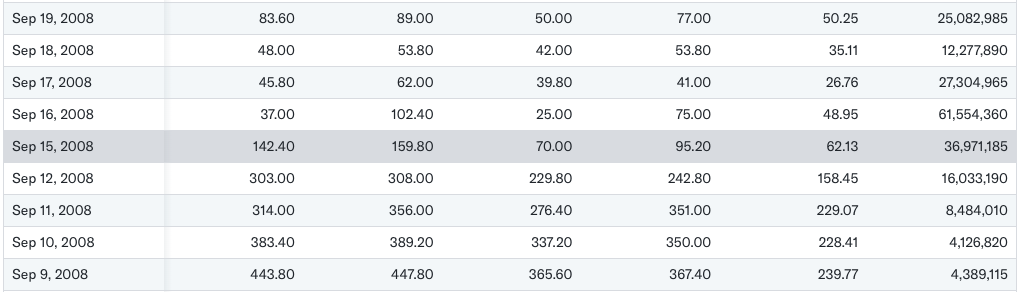

HIG: Hartford Financial Services Group Inc.
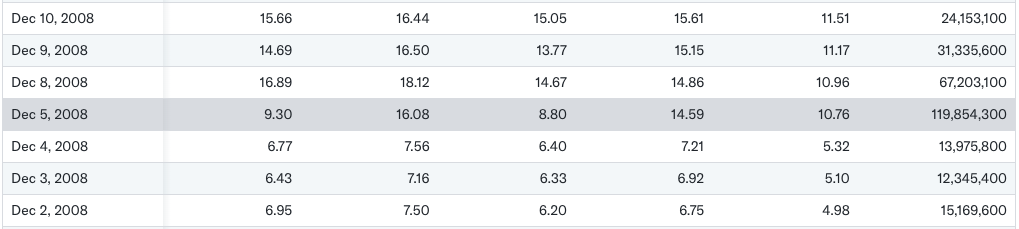

In [17]:
# Double check AIG's return on Setptember 15, 2008
(62.13-158.45)/158.45

-0.6078889239507731

In [18]:
# Double check HIG's return on December 5, 2008
(10.76-5.32)/5.32

1.0225563909774436

In [19]:
# Drop stocks (columns, hence axis = 1) with null values within this 10-year period
daily_return_cleaned_df = daily_return_df.dropna(axis=1)
daily_return_cleaned_df.isnull().sum()

MSFT     0
NVDA     0
AAPL     0
AMZN     0
BRK-B    0
LLY      0
JPM      0
XOM      0
UNH      0
PG       0
COST     0
JNJ      0
MRK      0
HD       0
NFLX     0
WMT      0
CVX      0
BAC      0
AMD      0
KO       0
ADBE     0
PEP      0
QCOM     0
ORCL     0
TMO      0
LIN      0
WFC      0
AMAT     0
ACN      0
CSCO     0
DIS      0
MCD      0
ABT      0
INTU     0
TXN      0
GE       0
VZ       0
AMGN     0
DHR      0
CAT      0
PFE      0
IBM      0
ISRG     0
MU       0
CMCSA    0
NEE      0
GS       0
SPGI     0
HON      0
LRCX     0
UNP      0
BKNG     0
RTX      0
COP      0
T        0
AXP      0
INTC     0
ETN      0
TJX      0
ELV      0
LOW      0
MS       0
VRTX     0
PGR      0
C        0
SYK      0
NKE      0
ADI      0
BSX      0
REGN     0
BLK      0
KLAC     0
SCHW     0
MDT      0
CB       0
MMC      0
ADP      0
PLD      0
BA       0
LMT      0
UPS      0
CI       0
DE       0
MDLZ     0
SNPS     0
AMT      0
SBUX     0
FI       0
GILD     0
BMY      0
SO       0

In [20]:
# See how many stocks are left after dropping stocks with null values
len(daily_return_cleaned_df.columns)

385

###**4. Get the correlation matrix**

In [21]:
correlation_matrix = daily_return_cleaned_df.corr()
correlation_matrix

MSFT      NVDA      AAPL      AMZN     BRK-B       LLY       JPM  \
MSFT   1.000000  0.511252  0.515875  0.513598  0.456937  0.397549  0.449748   
NVDA   0.511252  1.000000  0.457382  0.415434  0.353807  0.263925  0.355184   
AAPL   0.515875  0.457382  1.000000  0.445229  0.366615  0.290833  0.395235   
AMZN   0.513598  0.415434  0.445229  1.000000  0.331856  0.278473  0.347681   
BRK-B  0.456937  0.353807  0.366615  0.331856  1.000000  0.349591  0.595031   
LLY    0.397549  0.263925  0.290833  0.278473  0.349591  1.000000  0.350960   
JPM    0.449748  0.355184  0.395235  0.347681  0.595031  0.350960  1.000000   
XOM    0.413685  0.318555  0.342901  0.284270  0.480735  0.365667  0.481011   
UNH    0.401533  0.293262  0.342861  0.288249  0.403912  0.406178  0.395930   
PG     0.443251  0.270191  0.333419  0.264903  0.414461  0.445079  0.398159   
COST   0.474555  0.368124  0.399350  0.395421  0.392282  0.363945  0.391020   
JNJ    0.437820  0.259752  0.324062  0.293380  0.452258  0.543588  0.389527   
MRK    0.354761  0.234063  0.272717  0.234945  0.365969  0.502272  0.359778   
HD     0.513043  0.419567  0.437741  0.427355  0.490536  0.385856  0.544058   
NFLX   0.308203  0.311394  0.285967  0.387075  0.215339  0.167527  0.210371   
WMT    0.368883  0.255678  0.295634  0.279486  0.332654  0.356446  0.320335   
CVX    0.439914  0.341244  0.362173  0.294614  0.510441  0.365502  0.508004   
BAC    0.406236  0.329332  0.355395  0.311129  0.564155  0.309542  0.831071   
AMD    0.397004  0.516852  0.371567  0.343096  0.309295  0.223150  0.323042   
KO     0.447292  0.279668  0.331875  0.288912  0.453074  0.414868  0.405248   
ADBE   0.609636  0.516510  0.471358  0.475971  0.406386  0.358186  0.415143   
PEP    0.471047  0.289903  0.341651  0.302570  0.437893  0.446072  0.386427   
QCOM   0.502872  0.497033  0.473217  0.424127  0.372852  0.291948  0.406377   
ORCL   0.557312  0.438990  0.446304  0.396123  0.440119  0.382897  0.464053   
TMO    0.495921  0.421152  0.407549  0.417475  0.443130  0.423459  0.416179   
LIN    0.535151  0.442697  0.452720  0.379382  0.528621  0.393803  0.535080   
WFC    0.404137  0.313530  0.339233  0.310545  0.552182  0.324103  0.820263   
AMAT   0.549452  0.595566  0.473032  0.421339  0.435758  0.311996  0.466389   
ACN    0.544575  0.440900  0.410247  0.409367  0.482448  0.372758  0.443646   
CSCO   0.564022  0.478750  0.467732  0.414762  0.459508  0.391714  0.490533   
DIS    0.506830  0.404775  0.414696  0.410830  0.522243  0.348351  0.544584   
MCD    0.438804  0.315011  0.372280  0.315739  0.424378  0.325749  0.422162   
ABT    0.441392  0.304246  0.332709  0.302931  0.405289  0.477074  0.373239   
INTU   0.586742  0.479062  0.449469  0.456230  0.424366  0.359902  0.423563   
TXN    0.540875  0.587406  0.476425  0.423072  0.442193  0.336836  0.454502   
GE     0.393186  0.343550  0.370335  0.315641  0.517396  0.330266  0.591356   
VZ     0.399504  0.267869  0.304212  0.294631  0.396496  0.391973  0.431870   
AMGN   0.416652  0.282084  0.334103  0.310429  0.374337  0.452947  0.333662   
DHR    0.459822  0.390378  0.391148  0.368125  0.412594  0.367410  0.416032   
CAT    0.453275  0.400840  0.402077  0.352620  0.537276  0.334928  0.537191   
PFE    0.392249  0.273253  0.303153  0.286233  0.409222  0.517836  0.418652   
IBM    0.493990  0.379447  0.423260  0.356245  0.499030  0.360912  0.510494   
ISRG   0.398487  0.380893  0.379260  0.347012  0.342028  0.309072  0.346298   
MU     0.437601  0.517663  0.390787  0.353517  0.423089  0.270083  0.443329   
CMCSA  0.472283  0.378168  0.382056  0.362515  0.465966  0.388296  0.524414   
NEE    0.411269  0.273363  0.305006  0.266747  0.390079  0.384195  0.324126   
GS     0.478272  0.399399  0.425991  0.383776  0.582776  0.348622  0.757446   
SPGI   0.537686  0.432554  0.427079  0.400642  0.495224  0.408734  0.515897   
HON    0.532165  0.426653  0.437817  0.382913  0.572099  0.420004  0.589486   
LRCX   0.511189  0.585565  0.462823  0.417813  0.409234  0.28

pandas.DataFrame.corr() here uses Pearson correlation coefficient.
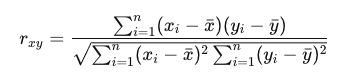

In [22]:
correlation_matrix[correlation_matrix < 0].stack()

Series([], dtype: float64)

###**5. Perform K-means clustering**

K-Means from Scikitlearn \

Default method of initialization of centroids: K-means++
1. Choose one center uniformly at random among the data points.
2. For each data point x not chosen yet, compute D(x), the distance between x and the nearest center that has already been chosen.
3. Choose one new data point at random as a new center, using a weighted probability distribution where a point x is chosen with probability proportional to D(x)^2.
4. Repeat Steps 2 and 3 until k centers have been chosen.
5. Now that the initial centers have been chosen, proceed using standard k-means clustering. \

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html \
https://en.wikipedia.org/wiki/K-means%2B%2B

In [23]:
import warnings
warnings.filterwarnings("ignore")

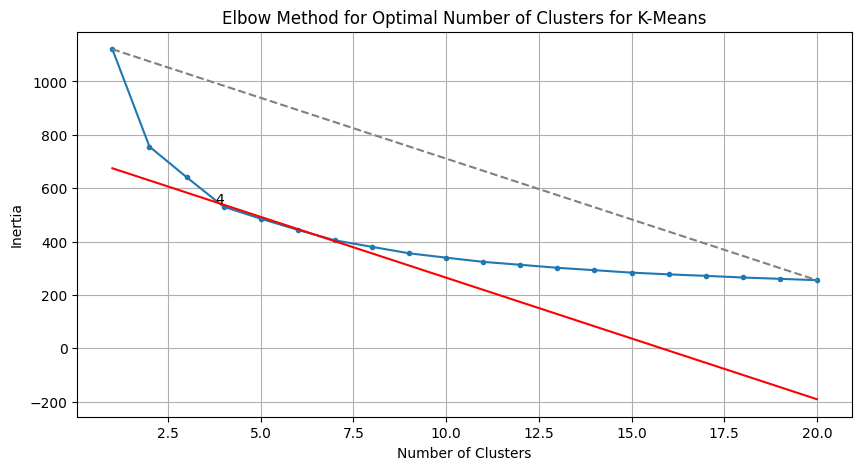

In [24]:
# Test out different values of n_clusters using the elbow method
# Try the numbers between 1 to 20
n_cluster_options = range(1, 21)

# inertia_: Sum of squared distances of samples to their closest cluster center
inertia_array = []

for n_cluster in n_cluster_options:
    kmeans = KMeans(n_clusters=n_cluster, random_state=123)
    kmeans.fit(correlation_matrix)
    inertia_array.append(kmeans.inertia_)

start_point = (n_cluster_options[0], inertia_array[0])
end_point = (n_cluster_options[-1], inertia_array[-1])
slope = (end_point[1] - start_point[1]) / (end_point[0] - start_point[0])

x_values = np.linspace(1, 20)
y_values = slope * x_values + 720

# Plot
plt.figure(figsize=(10, 5))
plt.plot(n_cluster_options, inertia_array, marker='.')
plt.plot([start_point[0], end_point[0]], [start_point[1], end_point[1]], linestyle='--', color='gray')
plt.plot(x_values, y_values, color='red')

plt.text(n_cluster_options[3], inertia_array[3], f'{n_cluster_options[3]}', ha='right', va='bottom')

plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters for K-Means')
plt.grid(True)
plt.show()

Based on the Elbow method graph above, it appears that 4 is the inflection point. We will proceed with n_cluster = 4 in our K-means algorithm.

In [25]:
# Perform K-means clustering with n_cluster = 4
kmeans = KMeans(n_clusters=4, random_state=123).fit(correlation_matrix)
kmeans_labels = kmeans.labels_

In [26]:
# Perform PCA with n_components = 2
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(correlation_matrix)

reduced_data.shape

(385, 2)

Text(0, 0.5, 'PCA Component 2')

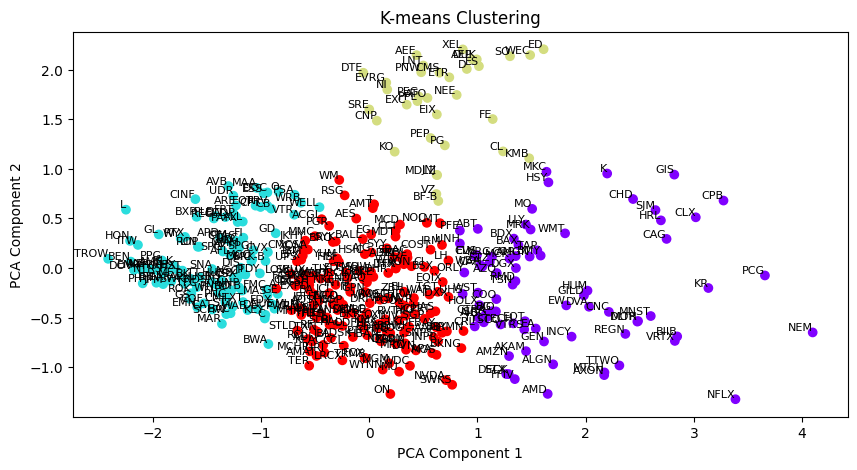

In [27]:
# Plot the K-means clusters
plt.figure(figsize=(10, 5))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=kmeans_labels, cmap='rainbow')
for i, ticker in enumerate(correlation_matrix.columns):
    plt.text(reduced_data[i, 0], reduced_data[i, 1], ticker, fontsize=8, ha='right', va='bottom')
plt.title('K-means Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

####**5.1 Get industry sector data**

Obtained sector data from

*   https://www.barchart.com/stocks/indices/sp-sector/consumer-discretionary
*   https://www.spglobal.com/spdji/en/index-family/equity/us-equity/sp-sectors/#indices



In [28]:
industry_sector = pd.read_csv("https://raw.githubusercontent.com/Hyshubham2504/Clustering-Project/main/Industry.csv")
industry_sector.head()

Ticker Symbol         Industry Sector
0          ABNB  Consumer Discretionary
1          AMZN  Consumer Discretionary
2          APTV  Consumer Discretionary
3           AZO  Consumer Discretionary
4          BBWI  Consumer Discretionary

In [29]:
# Create a dataframe with Ticker, Cluster (that the Ticker is assigned to), and Industry Sector as columns
ticker_cluster_df = pd.DataFrame({
    'Ticker Symbol': correlation_matrix.columns,
    'Cluster': kmeans_labels
})

ticker_cluster_sector_df = pd.merge(ticker_cluster_df, industry_sector, on='Ticker Symbol', how='left')
ticker_cluster_sector_df

Ticker Symbol  Cluster         Industry Sector
0            MSFT        3  Information Technology
1            NVDA        3  Information Technology
2            AAPL        3  Information Technology
3            AMZN        0  Consumer Discretionary
4           BRK-B        1              Financials
5             LLY        0             Health Care
6             JPM        1              Financials
7             XOM        3                  Energy
8             UNH        0             Health Care
9              PG        2        Customer Staples
10           COST        3        Customer Staples
11            JNJ        2             Health Care
12            MRK        0             Health Care
13             HD        1  Consumer Discretionary
14           NFLX        0  Communication Services
15            WMT        0        Customer Staples
16            CVX        1                  Energy
17            BAC        1              Financials
18            AMD        0  Information Technology
19             KO        2        Customer Staples
20           ADBE        3  Information Technology
21            PEP        2        Customer Staples
22           QCOM        3  Information Technology
23           ORCL        3  Information Technology
24            TMO        3             Health Care
25            LIN        1               Materials
26            WFC        1              Financials
27           AMAT        3  Information Technology
28            ACN        3  Information Technology
29           CSCO        3  Information Technology
30            DIS        1  Communication Services
31            MCD        3  Consumer Discretionary
32            ABT        0             Health Care
33           INTU        3  Information Technology
34            TXN        3  Information Technology
35             GE        1             Industrials
36             VZ        2  Communication Services
37           AMGN        0             Health Care
38            DHR        3             Health Care
39            CAT        1             Industrials
40            PFE        0             Health Care
41            IBM        3  Information Technology
42           ISRG        0             Health Care
43             MU        3  Information Technology
44          CMCSA        3  Communication Services
45            NEE        2               Utilities
46             GS        1              Financials
47           SPGI        1              Financials
48            HON        1             Industrials
49           LRCX        3  Information Technology
50            UNP        1             Industrials
51           BKNG        3  Consumer Discretionary
52            RTX        1             Industrials
53            COP        3                  Energy
54              T        3  Communication Services
55            AXP        1              Financials
56           INTC        3  Information Technology
57            ETN        1             Industrials
58            TJX        3  Consumer Discretionary
59            ELV        0             Health Care
60            LOW        3  Consumer Discretionary
61             MS        1              Financials
62           VRTX        0             Health Care
63            PGR        3              Financials
64              C        1              Financials
65            SYK        3             Health Care
66            NKE        3  Consumer Discretionary
67            ADI        3  Information Technology
68            BSX        3             Health Care
69           REGN        0             Health Care
70            BLK        1              Financials
71           KLAC        3  Information Technology
72           SCHW        1              Financials
73            MDT        3             Health Care
74             CB        1              Financials
75            MMC        3              Financials
76            ADP        1             Industrials
77            PLD        1

In [30]:
# Check if there is any ticker symbols that do not have Industry_Sector
ticker_cluster_sector_df[ticker_cluster_sector_df['Industry Sector'].isnull()]

Empty DataFrame
Columns: [Ticker Symbol, Cluster, Industry Sector]
Index: []

In [31]:
# Check the number of tickers that fall into each industry sector among these 388 tickers
ticker_cluster_sector_df['Industry Sector'].value_counts()

Industry Sector
Financials                56
Industrials               56
Health Care               53
Information Technology    48
Consumer Discretionary    38
Customer Staples          32
Utilities                 28
Real Estate               26
Materials                 21
Energy                    17
Communication Services    10
Name: count, dtype: int64

In [32]:
# Same as above, but in percentage
ticker_cluster_sector_df['Industry Sector'].value_counts(normalize=True)*100

Industry Sector
Financials                14.545455
Industrials               14.545455
Health Care               13.766234
Information Technology    12.467532
Consumer Discretionary     9.870130
Customer Staples           8.311688
Utilities                  7.272727
Real Estate                6.753247
Materials                  5.454545
Energy                     4.415584
Communication Services     2.597403
Name: proportion, dtype: float64

In [33]:
# Check the percentage of industry sectors in each cluster
sector_count_df = ticker_cluster_sector_df.groupby(['Cluster', 'Industry Sector']).size().unstack(fill_value=0)
sector_count_df

Industry Sector  Communication Services  Consumer Discretionary  \
Cluster                                                           
0                                     4                       5   
1                                     2                       4   
2                                     1                       0   
3                                     3                      29   

Industry Sector  Customer Staples  Energy  Financials  Health Care  \
Cluster                                                              
0                              20       2           1           36   
1                               0       1          37            0   
2                               7       0           0            1   
3                               5      14          18           16   

Industry Sector  Industrials  Information Technology  Materials  Real Estate  \
Cluster                                                                        
0                          1                       6          1            0   
1                         34                       3         10           20   
2                          0                       0          0            0   
3                         21                      39         10            6   

Industry Sector  Utilities  
Cluster                     
0                        2  
1                        0  
2                       25  
3                        1

In [34]:
# See the total number of ticker symbols in each cluster
total_cluster_count = sector_count_df.sum(axis=1)
total_cluster_count

Cluster
0     78
1    111
2     34
3    162
dtype: int64

In [35]:
# Find the percentage of industry sectors in each cluster
sector_percentage_df = sector_count_df.div(total_cluster_count, axis=0)*100
sector_percentage_df

Industry Sector  Communication Services  Consumer Discretionary  \
Cluster                                                           
0                              5.128205                6.410256   
1                              1.801802                3.603604   
2                              2.941176                0.000000   
3                              1.851852               17.901235   

Industry Sector  Customer Staples    Energy  Financials  Health Care  \
Cluster                                                                
0                       25.641026  2.564103    1.282051    46.153846   
1                        0.000000  0.900901   33.333333     0.000000   
2                       20.588235  0.000000    0.000000     2.941176   
3                        3.086420  8.641975   11.111111     9.876543   

Industry Sector  Industrials  Information Technology  Materials  Real Estate  \
Cluster                                                                        
0                   1.282051                7.692308   1.282051     0.000000   
1                  30.630631                2.702703   9.009009    18.018018   
2                   0.000000                0.000000   0.000000     0.000000   
3                  12.962963               24.074074   6.172840     3.703704   

Industry Sector  Utilities  
Cluster                     
0                 2.564103  
1                 0.000000  
2                73.529412  
3                 0.617284

In [36]:
for cluster in sector_percentage_df.index:
    print(f"Cluster {cluster}:")

    sorted_sectors = sector_percentage_df.loc[cluster].sort_values(ascending=False)

    for sector, percentage in sorted_sectors.items():
        print(f"  {sector}: {percentage:.2f}%")

    print("\n")

Cluster 0:
  Health Care: 46.15%
  Customer Staples: 25.64%
  Information Technology: 7.69%
  Consumer Discretionary: 6.41%
  Communication Services: 5.13%
  Energy: 2.56%
  Utilities: 2.56%
  Financials: 1.28%
  Industrials: 1.28%
  Materials: 1.28%
  Real Estate: 0.00%


Cluster 1:
  Financials: 33.33%
  Industrials: 30.63%
  Real Estate: 18.02%
  Materials: 9.01%
  Consumer Discretionary: 3.60%
  Information Technology: 2.70%
  Communication Services: 1.80%
  Energy: 0.90%
  Customer Staples: 0.00%
  Health Care: 0.00%
  Utilities: 0.00%


Cluster 2:
  Utilities: 73.53%
  Customer Staples: 20.59%
  Communication Services: 2.94%
  Health Care: 2.94%
  Consumer Discretionary: 0.00%
  Energy: 0.00%
  Financials: 0.00%
  Industrials: 0.00%
  Information Technology: 0.00%
  Materials: 0.00%
  Real Estate: 0.00%


Cluster 3:
  Information Technology: 24.07%
  Consumer Discretionary: 17.90%
  Industrials: 12.96%
  Financials: 11.11%
  Health Care: 9.88%
  Energy: 8.64%
  Materials: 6.17%
 

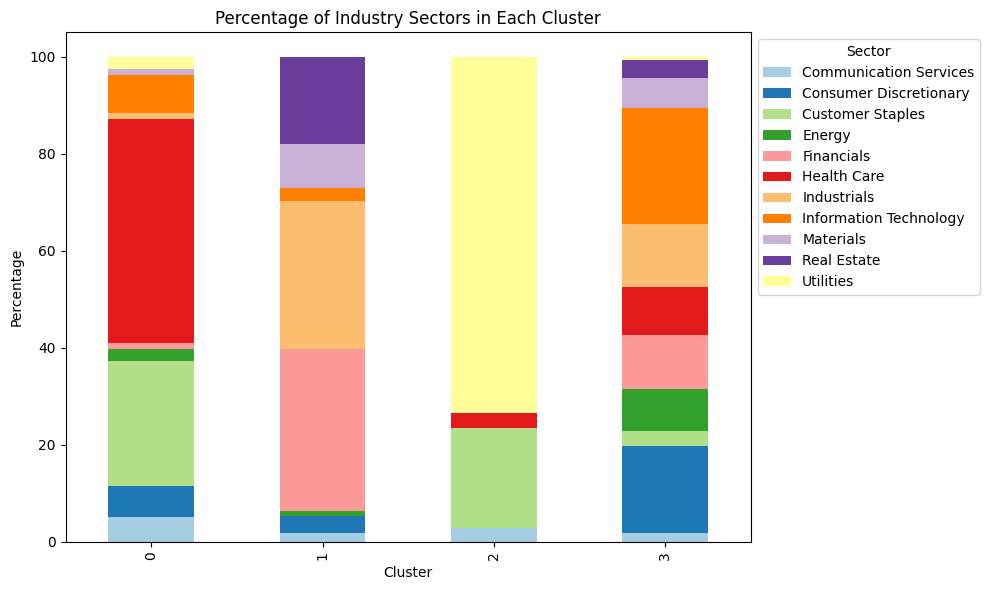

In [37]:
# Stacked bar chart
colors = sns.color_palette("Paired")

sector_percentage_df.plot(kind='bar', stacked=True, figsize=(10, 6), color=colors)
plt.title('Percentage of Industry Sectors in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Percentage')
plt.legend(title='Sector', bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

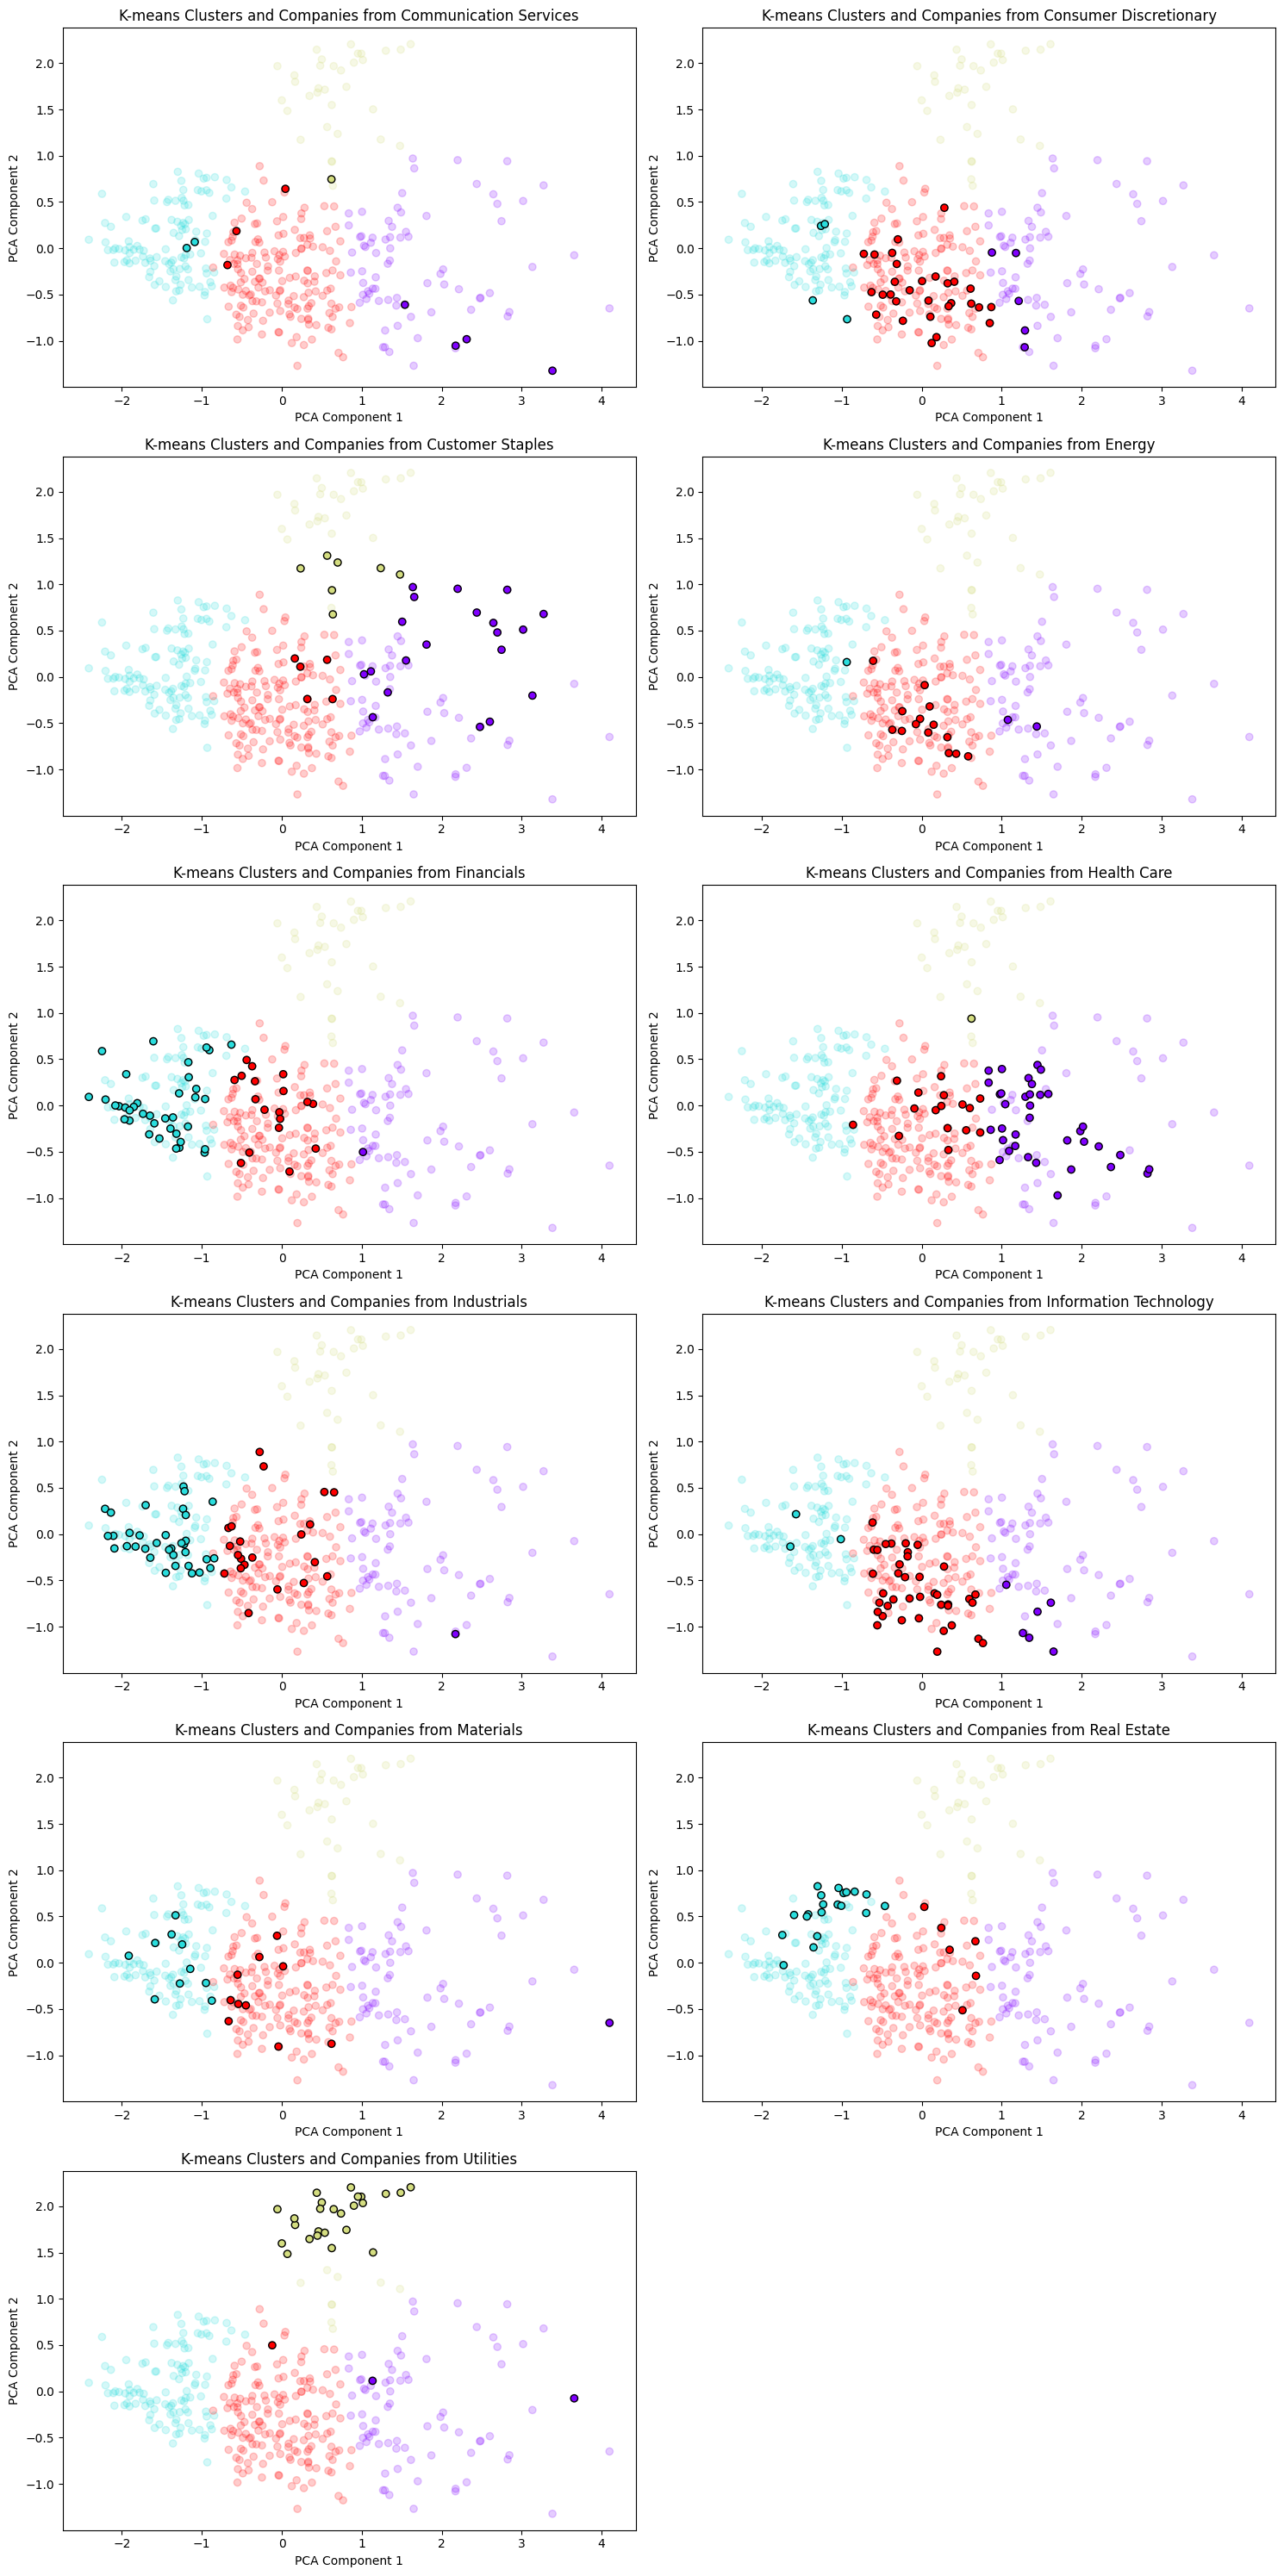

In [101]:
#https://matplotlib.org/stable/api/_as_gen/matplotlib.colors.ListedColormap.html

tickers_category = ['Communication Services', 'Consumer Discretionary', 'Customer Staples', 'Energy', 'Financials', 'Health Care', 'Industrials', 'Information Technology', 'Materials', 'Real Estate', 'Utilities']

figure, axis = plt.subplots(6, 2, figsize=(15, 30))
axis = axis.flatten()

# Create a colormap from the k-means labels
unique_labels_length = len(np.unique(kmeans_labels))
cmap = ListedColormap(plt.cm.rainbow(np.linspace(0, 1, unique_labels_length)))
colors = cmap(kmeans_labels)

for i, ax in enumerate(axis):
    if i >= len(tickers_category):
        ax.axis('off')
        continue

    highlighted_mask = np.zeros(reduced_data.shape[0], dtype=bool)
    ticker_list = ticker_cluster_sector_df[ticker_cluster_sector_df['Industry Sector'] == tickers_category[i]]['Ticker Symbol'].to_numpy()

    # Mark the highlighted tickers
    for ticker in ticker_list:
        if ticker in correlation_matrix.columns:
            ticker_index = correlation_matrix.columns.get_loc(ticker)
            highlighted_mask[ticker_index] = True

    # Other tickers with reduced opacity
    ax.scatter(reduced_data[:, 0], reduced_data[:, 1], c=colors, alpha=0.2)

    # Highlighted tickers with full opacity
    ax.scatter(reduced_data[highlighted_mask, 0], reduced_data[highlighted_mask, 1], c=colors[highlighted_mask], edgecolors='black', alpha=1.0)

    ax.set_title(f'K-means Clusters and Companies from {tickers_category[i]}')
    ax.set_xlabel('PCA Component 1')
    ax.set_ylabel('PCA Component 2')

plt.tight_layout()
plt.show()

###**6. Perform hierarchical clustering**
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering \

https://jbhender.github.io/Stats506/F18/GP/Group15.html

In [40]:
def wss_calculation(K, data):
    WSS = []
    for i in range(K):
        cluster = AgglomerativeClustering(n_clusters=i + 1)
        labels = cluster.fit_predict(data)
        wss = []
        for j in range(i + 1):
            # extract each cluster according to its index
            cluster_data = data[labels == j]
            cluster_mean = cluster_data.mean(axis=0)
            distance = np.sum(np.square(cluster_data - cluster_mean))
            wss.append(sum(distance))
        WSS.append(sum(wss))
    return WSS

In [41]:
WSS = wss_calculation(20, correlation_matrix)

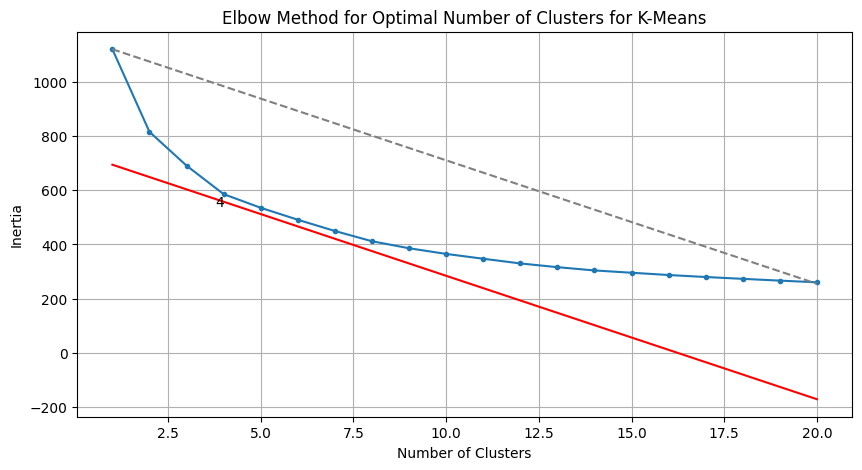

In [42]:
n_cluster_options = range(1, 21)

start_point = (n_cluster_options[0], inertia_array[0])
end_point = (n_cluster_options[-1], inertia_array[-1])
slope = (end_point[1] - start_point[1]) / (end_point[0] - start_point[0])

x_values = np.linspace(1, 20)
y_values = slope * x_values + 740

# Plot
plt.figure(figsize=(10, 5))
plt.plot(n_cluster_options, WSS, marker='.')
plt.plot([start_point[0], end_point[0]], [start_point[1], end_point[1]], linestyle='--', color='gray')
plt.plot(x_values, y_values, color='red')

plt.text(n_cluster_options[3], inertia_array[3], f'{n_cluster_options[3]}', ha='right', va='bottom')

plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters for K-Means')
plt.grid(True)
plt.show()

Based on the Elbow method graph above, it appears that 4 is the inflection point. We will proceed with n_cluster = 4 in our hierarchical clustering algorithm.

In [43]:
hierarchical_clustering = AgglomerativeClustering(n_clusters = 4).fit(correlation_matrix)
hierarchical_labels = hierarchical_clustering.labels_

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(correlation_matrix)

Text(0, 0.5, 'PCA Component 2')

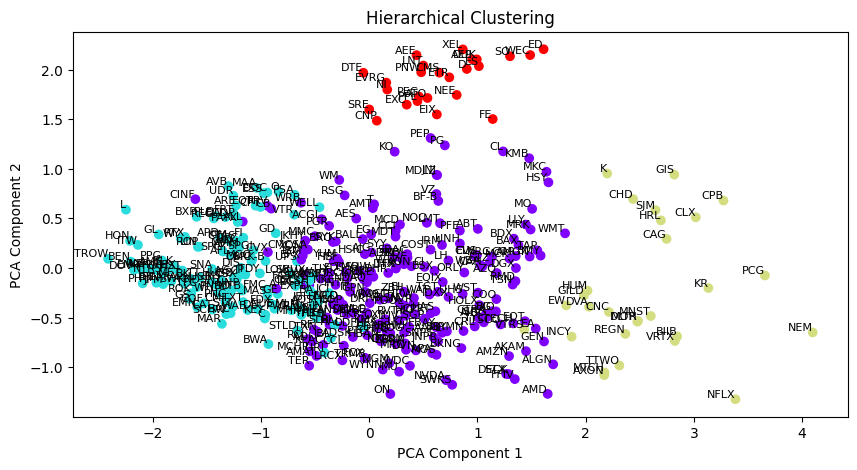

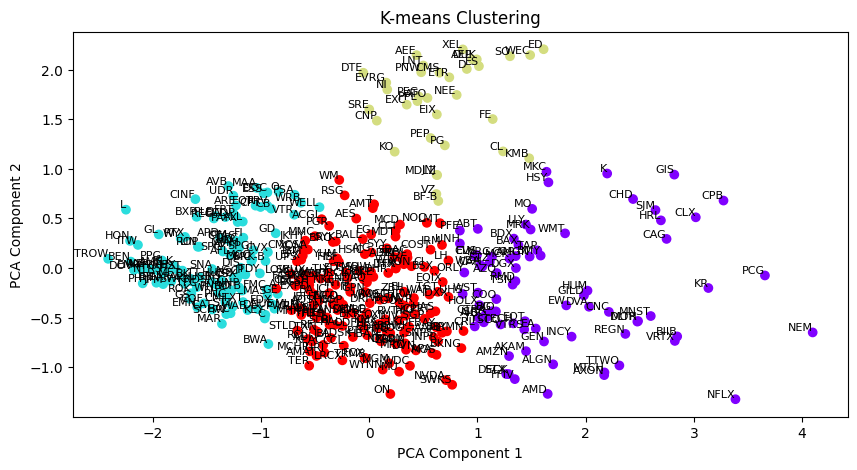

In [44]:
# Plot the hierarchical clusters
plt.figure(figsize=(10, 5))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=hierarchical_labels, cmap='rainbow')
for i, ticker in enumerate(correlation_matrix.columns):
    plt.text(reduced_data[i, 0], reduced_data[i, 1], ticker, fontsize=8, ha='right', va='bottom')
plt.title('Hierarchical Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

# Plot the K-means clusters
plt.figure(figsize=(10, 5))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=kmeans_labels, cmap='rainbow')
for i, ticker in enumerate(correlation_matrix.columns):
    plt.text(reduced_data[i, 0], reduced_data[i, 1], ticker, fontsize=8, ha='right', va='bottom')
plt.title('K-means Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

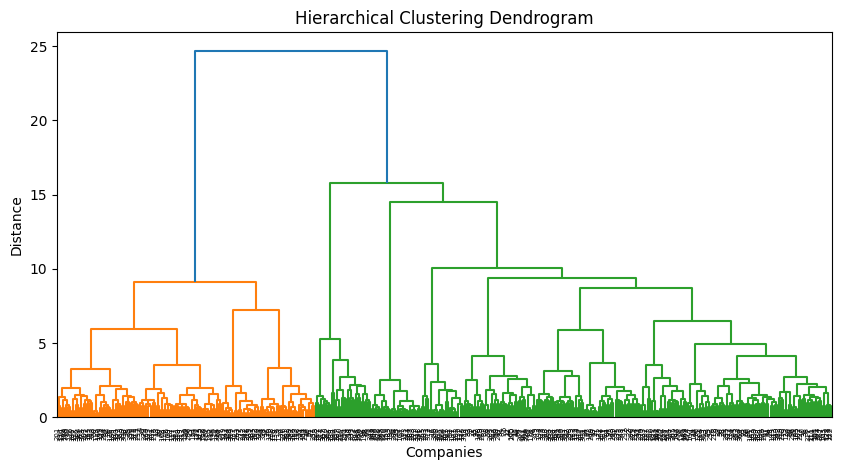

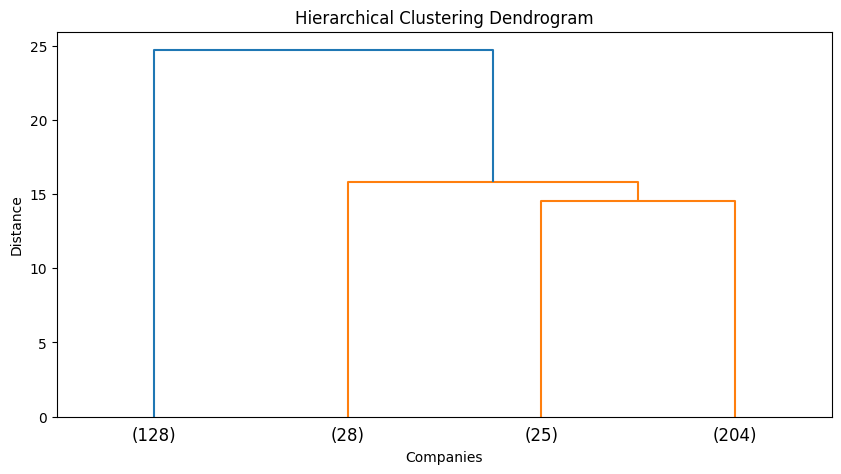

In [45]:
link = linkage(correlation_matrix, method='ward')  #AgglomerativeClustering from scikitlearn uses linkage=ward by default, so use ward here as well

# Plot dendrogram
plt.figure(figsize=(10, 5))
dendrogram(link)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Companies')
plt.ylabel('Distance')
plt.show()

plt.figure(figsize=(10, 5))
dendrogram(link, truncate_mode='lastp', p=4)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Companies')
plt.ylabel('Distance')
plt.show()

####**6.1 Get industry sector data**

In [46]:
# Create a dataframe with Ticker, Cluster (that the Ticker is assigned to), and Industry Sector as columns
ticker_cluster_df_hierarchical = pd.DataFrame({
    'Ticker Symbol': correlation_matrix.columns,
    'Cluster': hierarchical_labels
})

ticker_cluster_sector_df_hierarchical = pd.merge(ticker_cluster_df_hierarchical, industry_sector, on='Ticker Symbol', how='left')
ticker_cluster_sector_df_hierarchical

Ticker Symbol  Cluster         Industry Sector
0            MSFT        0  Information Technology
1            NVDA        0  Information Technology
2            AAPL        0  Information Technology
3            AMZN        0  Consumer Discretionary
4           BRK-B        1              Financials
5             LLY        0             Health Care
6             JPM        1              Financials
7             XOM        0                  Energy
8             UNH        0             Health Care
9              PG        0        Customer Staples
10           COST        0        Customer Staples
11            JNJ        0             Health Care
12            MRK        0             Health Care
13             HD        1  Consumer Discretionary
14           NFLX        2  Communication Services
15            WMT        0        Customer Staples
16            CVX        0                  Energy
17            BAC        1              Financials
18            AMD        0  Information Technology
19             KO        0        Customer Staples
20           ADBE        0  Information Technology
21            PEP        0        Customer Staples
22           QCOM        0  Information Technology
23           ORCL        0  Information Technology
24            TMO        0             Health Care
25            LIN        1               Materials
26            WFC        1              Financials
27           AMAT        0  Information Technology
28            ACN        0  Information Technology
29           CSCO        0  Information Technology
30            DIS        1  Communication Services
31            MCD        0  Consumer Discretionary
32            ABT        0             Health Care
33           INTU        0  Information Technology
34            TXN        0  Information Technology
35             GE        1             Industrials
36             VZ        0  Communication Services
37           AMGN        0             Health Care
38            DHR        0             Health Care
39            CAT        1             Industrials
40            PFE        0             Health Care
41            IBM        0  Information Technology
42           ISRG        0             Health Care
43             MU        0  Information Technology
44          CMCSA        0  Communication Services
45            NEE        3               Utilities
46             GS        1              Financials
47           SPGI        1              Financials
48            HON        1             Industrials
49           LRCX        0  Information Technology
50            UNP        1             Industrials
51           BKNG        0  Consumer Discretionary
52            RTX        1             Industrials
53            COP        0                  Energy
54              T        0  Communication Services
55            AXP        1              Financials
56           INTC        0  Information Technology
57            ETN        1             Industrials
58            TJX        0  Consumer Discretionary
59            ELV        0             Health Care
60            LOW        1  Consumer Discretionary
61             MS        1              Financials
62           VRTX        2             Health Care
63            PGR        0              Financials
64              C        1              Financials
65            SYK        0             Health Care
66            NKE        0  Consumer Discretionary
67            ADI        0  Information Technology
68            BSX        0             Health Care
69           REGN        2             Health Care
70            BLK        1              Financials
71           KLAC        0  Information Technology
72           SCHW        1              Financials
73            MDT        0             Health Care
74             CB        0              Financials
75            MMC        0              Financials
76            ADP        1             Industrials
77            PLD        1

In [47]:
# Check if there is any ticker symbols that do not have Industry_Sector
ticker_cluster_sector_df_hierarchical[ticker_cluster_sector_df_hierarchical['Industry Sector'].isnull()]

Empty DataFrame
Columns: [Ticker Symbol, Cluster, Industry Sector]
Index: []

In [48]:
# Check the number of tickers that fall into each industry sector among these 388 tickers
ticker_cluster_sector_df_hierarchical['Industry Sector'].value_counts()

Industry Sector
Financials                56
Industrials               56
Health Care               53
Information Technology    48
Consumer Discretionary    38
Customer Staples          32
Utilities                 28
Real Estate               26
Materials                 21
Energy                    17
Communication Services    10
Name: count, dtype: int64

In [49]:
# Same as above, but in percentage
ticker_cluster_sector_df_hierarchical['Industry Sector'].value_counts(normalize=True)*100

Industry Sector
Financials                14.545455
Industrials               14.545455
Health Care               13.766234
Information Technology    12.467532
Consumer Discretionary     9.870130
Customer Staples           8.311688
Utilities                  7.272727
Real Estate                6.753247
Materials                  5.454545
Energy                     4.415584
Communication Services     2.597403
Name: proportion, dtype: float64

In [50]:
# Check the percentage of industry sectors in each cluster
sector_count_df_hierarchical = ticker_cluster_sector_df_hierarchical.groupby(['Cluster', 'Industry Sector']).size().unstack(fill_value=0)
sector_count_df_hierarchical

Industry Sector  Communication Services  Consumer Discretionary  \
Cluster                                                           
0                                     4                      30   
1                                     3                       8   
2                                     3                       0   
3                                     0                       0   

Industry Sector  Customer Staples  Energy  Financials  Health Care  \
Cluster                                                              
0                              21      17          24           42   
1                               0       0          32            0   
2                              11       0           0           11   
3                               0       0           0            0   

Industry Sector  Industrials  Information Technology  Materials  Real Estate  \
Cluster                                                                        
0                         10                      43          5            6   
1                         45                       5         15           20   
2                          1                       0          1            0   
3                          0                       0          0            0   

Industry Sector  Utilities  
Cluster                     
0                        2  
1                        0  
2                        1  
3                       25

In [51]:
# See the total number of ticker symbols in each cluster
total_cluster_count_hierarchical = sector_count_df_hierarchical.sum(axis=1)
total_cluster_count_hierarchical

Cluster
0    204
1    128
2     28
3     25
dtype: int64

In [52]:
# Find the percentage of industry sectors in each cluster
sector_percentage_df_hierarchical = sector_count_df_hierarchical.div(total_cluster_count_hierarchical, axis=0)*100
sector_percentage_df_hierarchical

Industry Sector  Communication Services  Consumer Discretionary  \
Cluster                                                           
0                              1.960784               14.705882   
1                              2.343750                6.250000   
2                             10.714286                0.000000   
3                              0.000000                0.000000   

Industry Sector  Customer Staples    Energy  Financials  Health Care  \
Cluster                                                                
0                       10.294118  8.333333   11.764706    20.588235   
1                        0.000000  0.000000   25.000000     0.000000   
2                       39.285714  0.000000    0.000000    39.285714   
3                        0.000000  0.000000    0.000000     0.000000   

Industry Sector  Industrials  Information Technology  Materials  Real Estate  \
Cluster                                                                        
0                   4.901961               21.078431   2.450980     2.941176   
1                  35.156250                3.906250  11.718750    15.625000   
2                   3.571429                0.000000   3.571429     0.000000   
3                   0.000000                0.000000   0.000000     0.000000   

Industry Sector   Utilities  
Cluster                      
0                  0.980392  
1                  0.000000  
2                  3.571429  
3                100.000000

In [53]:
for cluster in sector_percentage_df_hierarchical.index:
    print(f"Cluster {cluster}:")

    sorted_sectors_hierarchical = sector_percentage_df_hierarchical.loc[cluster].sort_values(ascending=False)

    for sector, percentage in sorted_sectors_hierarchical.items():
        print(f"  {sector}: {percentage:.2f}%")

    print("\n")

Cluster 0:
  Information Technology: 21.08%
  Health Care: 20.59%
  Consumer Discretionary: 14.71%
  Financials: 11.76%
  Customer Staples: 10.29%
  Energy: 8.33%
  Industrials: 4.90%
  Real Estate: 2.94%
  Materials: 2.45%
  Communication Services: 1.96%
  Utilities: 0.98%


Cluster 1:
  Industrials: 35.16%
  Financials: 25.00%
  Real Estate: 15.62%
  Materials: 11.72%
  Consumer Discretionary: 6.25%
  Information Technology: 3.91%
  Communication Services: 2.34%
  Customer Staples: 0.00%
  Energy: 0.00%
  Health Care: 0.00%
  Utilities: 0.00%


Cluster 2:
  Customer Staples: 39.29%
  Health Care: 39.29%
  Communication Services: 10.71%
  Industrials: 3.57%
  Materials: 3.57%
  Utilities: 3.57%
  Consumer Discretionary: 0.00%
  Energy: 0.00%
  Financials: 0.00%
  Information Technology: 0.00%
  Real Estate: 0.00%


Cluster 3:
  Utilities: 100.00%
  Communication Services: 0.00%
  Consumer Discretionary: 0.00%
  Customer Staples: 0.00%
  Energy: 0.00%
  Financials: 0.00%
  Health Care:

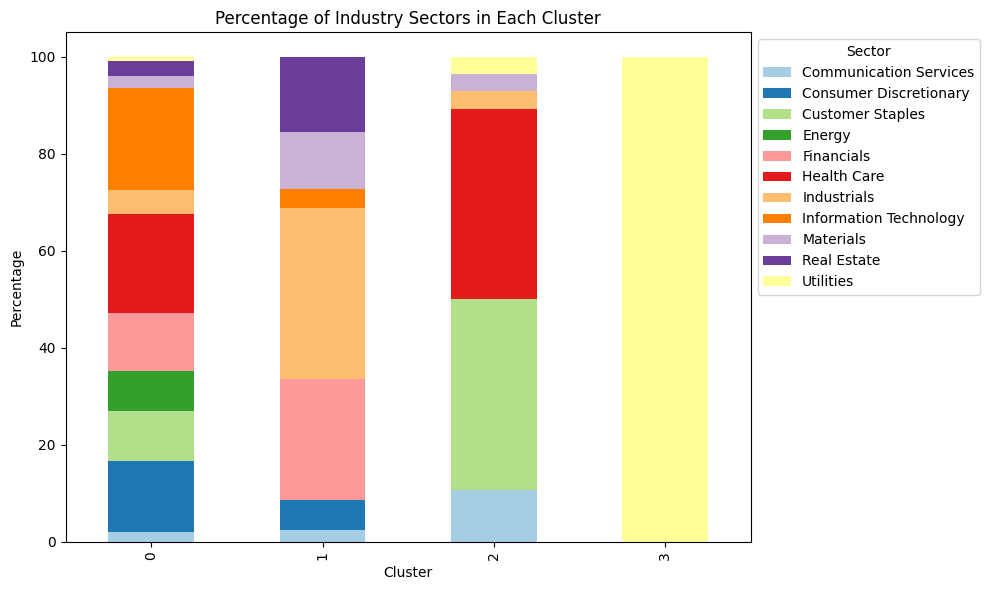

In [54]:
# Stacked bar chart
colors = sns.color_palette("Paired")

sector_percentage_df_hierarchical.plot(kind='bar', stacked=True, figsize=(10, 6), color=colors)
plt.title('Percentage of Industry Sectors in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Percentage')
plt.legend(title='Sector', bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

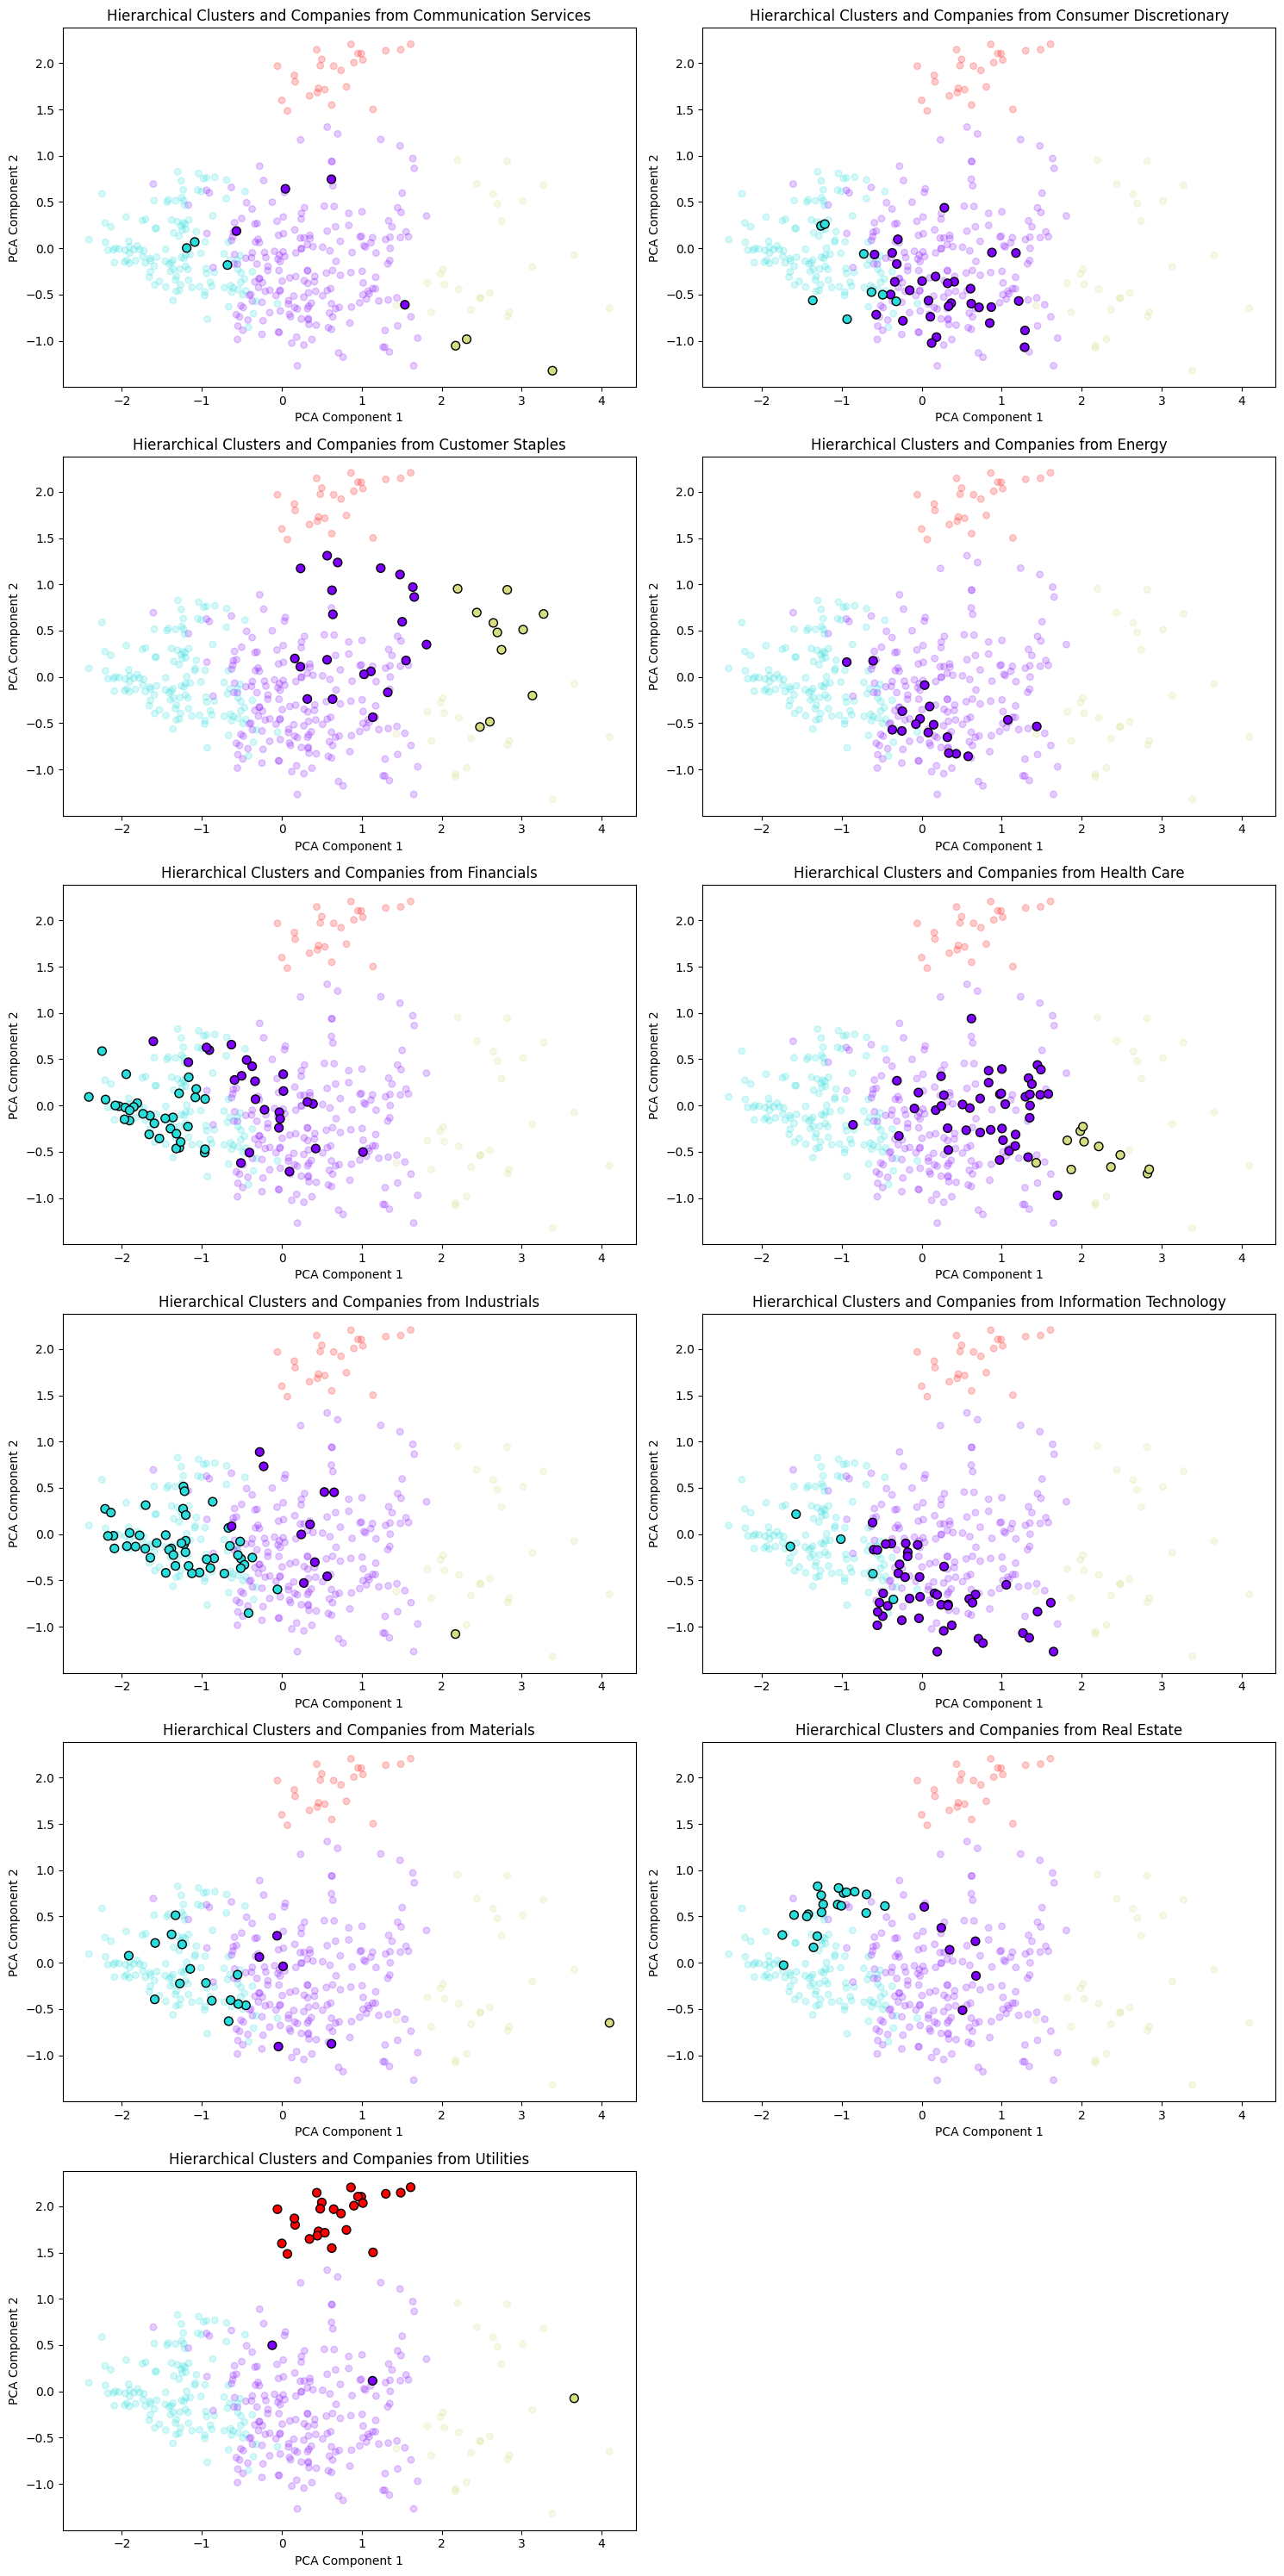

In [99]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
#https://matplotlib.org/stable/api/_as_gen/matplotlib.colors.ListedColormap.html

tickers_category = ['Communication Services', 'Consumer Discretionary', 'Customer Staples', 'Energy', 'Financials', 'Health Care', 'Industrials', 'Information Technology', 'Materials', 'Real Estate', 'Utilities']

figure, axis = plt.subplots(6, 2, figsize=(15, 30))
axis = axis.flatten()

# Create a colormap from the hierarchical labels
unique_labels_length = len(np.unique(hierarchical_labels))
cmap = ListedColormap(plt.cm.rainbow(np.linspace(0, 1, unique_labels_length)))
colors = cmap(hierarchical_labels)

for i, ax in enumerate(axis):
    if i >= len(tickers_category):
        ax.axis('off')
        continue

    highlighted_mask = np.zeros(reduced_data.shape[0], dtype=bool)
    ticker_list = ticker_cluster_sector_df[ticker_cluster_sector_df['Industry Sector'] == tickers_category[i]]['Ticker Symbol'].to_numpy()

    # Mark the highlighted tickers
    for ticker in ticker_list:
        if ticker in correlation_matrix.columns:
            ticker_index = correlation_matrix.columns.get_loc(ticker)
            highlighted_mask[ticker_index] = True

    # Other tickers with reduced opacity
    ax.scatter(reduced_data[:, 0], reduced_data[:, 1], c=colors, alpha=0.2, s=30)

    # Highlighted tickers with full opacity
    ax.scatter(reduced_data[highlighted_mask, 0], reduced_data[highlighted_mask, 1],
               c=colors[highlighted_mask], edgecolors='black', alpha=1.0, s=50)

    ax.set_title(f'Hierarchical Clusters and Companies from {tickers_category[i]}')
    ax.set_xlabel('PCA Component 1')
    ax.set_ylabel('PCA Component 2')

plt.tight_layout()
plt.show()